In [6]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directories
results_dir = "../results"
bias_results_dir = os.path.join(results_dir, "bias_scenarios")

# Make sure folder exists
assert os.path.exists(bias_results_dir), "⚠️ Bias results folder not found!"
print("✅ Results directory found:", bias_results_dir)

✅ Results directory found: ../results\bias_scenarios


In [7]:
import json

# --- Load baseline metrics ---
baseline_path = os.path.join(results_dir, "baseline_model_metrics.csv")
baseline_df = pd.read_csv(baseline_path)
baseline_df = baseline_df.dropna(subset=["precision", "recall", "f1-score"], how="any")
baseline_df["scenario"] = "baseline"

# --- Load bias scenario results ---
bias_dfs = []

for file in os.listdir(bias_results_dir):
    if file.endswith(".json"):
        path = os.path.join(bias_results_dir, file)
        with open(path, "r") as f:
            data = json.load(f)

        # Keep only entries that are dicts (ignore plain numbers like 'accuracy')
        cleaned = {k: v for k, v in data.items() if isinstance(v, dict)}
        df = pd.DataFrame(cleaned).transpose()
        df = df.dropna(subset=["precision", "recall", "f1-score"], how="any")
        df["scenario"] = file.replace(".json", "")
        bias_dfs.append(df)

# --- Combine all results ---
all_results = pd.concat([baseline_df] + bias_dfs, axis=0)
print("✅ Loaded scenarios:", all_results["scenario"].unique())


✅ Loaded scenarios: ['baseline' 'bias_gender_female_bias' 'bias_gender_male_bias'
 'bias_label_imbalance_class0' 'bias_label_noise_5pct'
 'bias_region_asia_bias' 'bias_region_eu_bias'
 'bias_underrepresented_class1']


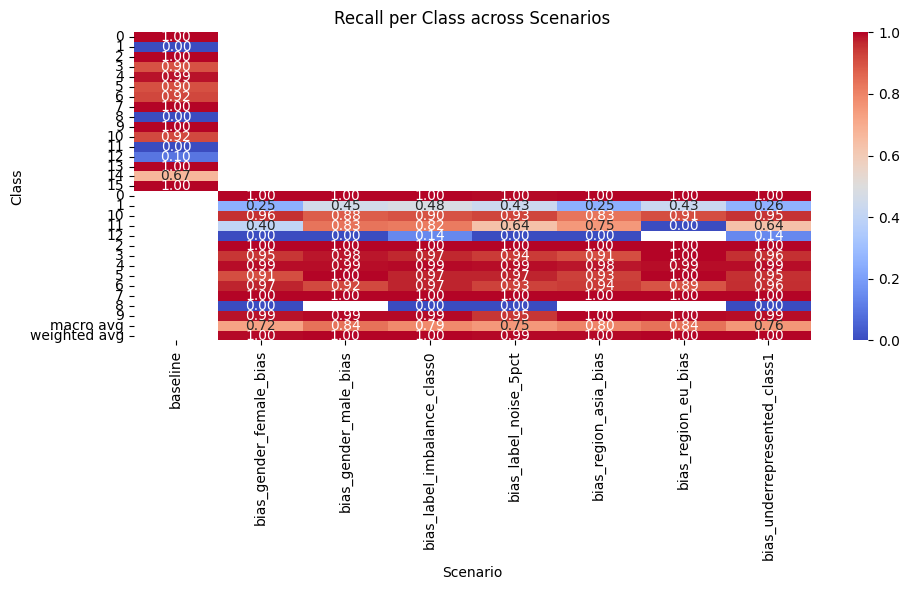

In [8]:
# Focus on recall for main comparison
recall_df = all_results.reset_index().rename(columns={"index": "class"})
recall_pivot = recall_df.pivot(index="class", columns="scenario", values="recall")

plt.figure(figsize=(10, 6))
sns.heatmap(recall_pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Recall per Class across Scenarios")
plt.xlabel("Scenario")
plt.ylabel("Class")
plt.tight_layout()
plt.show()


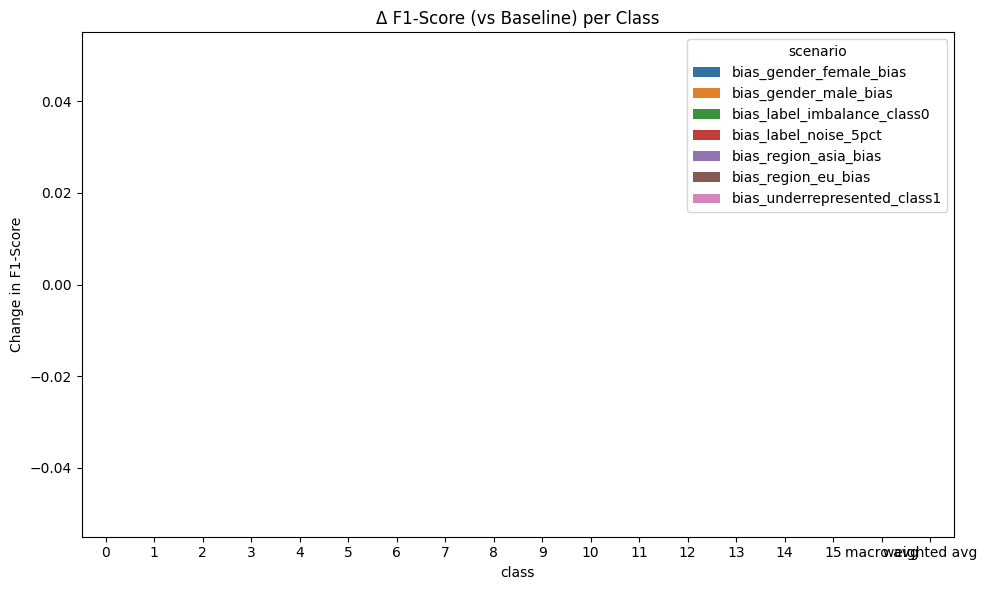

In [9]:
# Compute F1 delta vs baseline
f1_df = all_results.reset_index().rename(columns={"index": "class"})
baseline_f1 = f1_df[f1_df["scenario"] == "baseline"][["class", "f1-score"]].set_index("class")

diffs = []
for scenario in f1_df["scenario"].unique():
    if scenario == "baseline":
        continue
    merged = f1_df[f1_df["scenario"] == scenario].set_index("class")[["f1-score"]]
    delta = merged - baseline_f1
    delta["scenario"] = scenario
    diffs.append(delta.reset_index())

delta_df = pd.concat(diffs)
plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="class", y="f1-score", hue="scenario")
plt.title("Δ F1-Score (vs Baseline) per Class")
plt.ylabel("Change in F1-Score")
plt.tight_layout()
plt.show()


In [10]:
summary = recall_pivot.copy()
summary["avg_recall"] = summary.mean(axis=1)
summary.loc["overall_avg"] = summary.mean()

display(summary.round(3))

summary_path = os.path.join(results_dir, "bias_summary.csv")
summary.to_csv(summary_path)
print("✅ Summary table saved at:", summary_path)


scenario,baseline,bias_gender_female_bias,bias_gender_male_bias,bias_label_imbalance_class0,bias_label_noise_5pct,bias_region_asia_bias,bias_region_eu_bias,bias_underrepresented_class1,avg_recall
class,,,,,,,,,
0,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000
1,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2,0.999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999
3,0.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.900
4,0.986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986
5,0.903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903
6,0.921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921
7,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000
8,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000


✅ Summary table saved at: ../results\bias_summary.csv


In [11]:
# Save combined evaluation data for visualization notebook
output_path = os.path.join(results_dir, "all_results.csv")
all_results.to_csv(output_path, index=False)
print("✅ Saved combined results to:", output_path)

✅ Saved combined results to: ../results\all_results.csv
